In [3]:
import pandas as pd

In [17]:
data = pd.read_csv('data_ml.csv')

C:\Users\la96b\AppData\Local\Temp\ipykernel_23376\2320871898.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_ml.csv')


In [41]:
merge_data = pd.read_csv('metadata_all.csv')

In [43]:
merge_data.head()

,Run,BioProject,Age,Sex,BMI,Country,Continent,Ethnicity,Study.Group,author
0,SRR6166631,PRJNA397112,61.0,M,19.5,India,Asia,Asian,Healthy,Dhakan-2019
1,SRR6166632,PRJNA397112,58.0,M,19.2,India,Asia,Asian,Healthy,Dhakan-2019
2,SRR6166633,PRJNA397112,50.0,F,17.9,India,Asia,Asian,Healthy,Dhakan-2019
3,SRR6166634,PRJNA397112,62.0,M,20.8,India,Asia,Asian,Healthy,Dhakan-2019
4,SRR6166635,PRJNA397112,52.0,F,23.0,India,Asia,Asian,Healthy,Dhakan-2019


In [65]:
all_data = pd.merge(data, merge_data[['Age', 'Sex', 'BMI', 'Country', 'Continent', 'Study.Group', 'Run']], left_on = 'Unnamed: 0', right_on = 'Run', how = 'inner')

In [67]:
all_data.head()

,Unnamed: 0,Ethnicity,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,...,ASV26353,ASV26354,ASV26355,Age,Sex,BMI,Country,Continent,Study.Group,Run
0,SRR6166631,Asian,0.0,0.0,0.0,8.039480,0.000000,5.488938,0.0,0.0,...,0.0,0.0,0.0,61.0,M,19.5,India,Asia,Healthy,SRR6166631
1,SRR6166632,Asian,0.0,0.0,0.0,5.393628,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,58.0,M,19.2,India,Asia,Healthy,SRR6166632
2,SRR6166633,Asian,0.0,0.0,0.0,0.000000,3.433987,0.000000,0.0,0.0,...,0.0,0.0,0.0,50.0,F,17.9,India,Asia,Healthy,SRR6166633
3,SRR6166634,Asian,0.0,0.0,0.0,0.000000,0.000000,5.117994,0.0,0.0,...,0.0,0.0,0.0,62.0,M,20.8,India,Asia,Healthy,SRR6166634
4,SRR6166635,Asian,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,52.0,F,23.0,India,Asia,Healthy,SRR6166635


In [69]:
!pip install xgboost
!pip install lightgbm

In [338]:
# First cell - Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [229]:
df = all_data.copy()

# Display the first few rows of the dataset
df.head(1)

,Unnamed: 0,Ethnicity,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,...,ASV26353,ASV26354,ASV26355,Age,Sex,BMI,Country,Continent,Study.Group,Run
0,SRR6166631,Asian,0.0,0.0,0.0,8.03948,0.0,5.488938,0.0,0.0,...,0.0,0.0,0.0,61.0,M,19.5,India,Asia,Healthy,SRR6166631


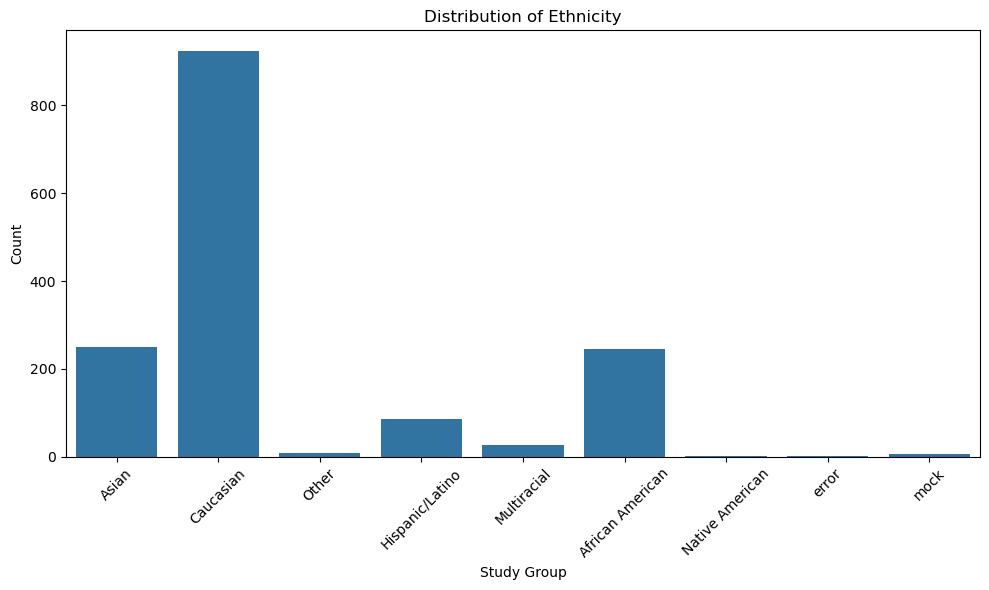

In [156]:

# Fourth cell - Visualize data distribution
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Ethnicity')
plt.title('Distribution of Ethnicity')
plt.xlabel('Study Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Treat NAs

In [232]:
numerical_cols = df.select_dtypes(include=np.number).columns
string_cols = df.select_dtypes(include='object').columns

# Create a dictionary for fill values
fill_values = {}
for col in numerical_cols:
    fill_values[col] = 0
for col in string_cols:
    fill_values[col] = ' '

# Fill NaN values using the dictionary
df.fillna(value=fill_values, inplace=True)


In [234]:
df['Ethnicity'].value_counts()

Ethnicity
Caucasian           925
Asian               250
African American    245
Hispanic/Latino      85
                     70
Multiracial          27
Other                 9
mock                  5
Native American       2
error                 2
Name: count, dtype: int64

In [235]:
df = df[df['Ethnicity'] != 'error']
df = df[df['Ethnicity'] != ' ']
df = df[df['Ethnicity'] != 'Native American']
df = df[df['Ethnicity'] != 'mock']

In [236]:
df['Ethnicity'].value_counts()

Ethnicity
Caucasian           925
Asian               250
African American    245
Hispanic/Latino      85
Multiracial          27
Other                 9
Name: count, dtype: int64

In [240]:
# Fifth cell - Split data into development, validation, and test sets (80-10-10)
def split_data(df, target_col='Ethnicity'):
    """
    Split data into development (80%), validation (10%), and test (10%) sets.
    """
    # First split: 80% development, 20% remaining
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    X_dev, X_temp, y_dev, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Second split: divide the remaining 20% into validation (10%) and test (10%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Development set: {X_dev.shape[0]} samples ({X_dev.shape[0]/X.shape[0]:.1%})")
    print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/X.shape[0]:.1%})")
    print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]:.1%})")
    
    return X_dev, X_val, X_test, y_dev, y_val, y_test

# Split the data
X_dev, X_val, X_test, y_dev, y_val, y_test = split_data(df)

Development set: 1078 samples (70.0%)
Validation set: 231 samples (15.0%)
Test set: 232 samples (15.1%)


In [242]:
X_dev.head()

,Unnamed: 0,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,...,ASV26353,ASV26354,ASV26355,Age,Sex,BMI,Country,Continent,Study.Group,Run
463,SRR18588637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.00000,M,31.22755,USA,North America,Healthy,SRR18588637
421,SRR18588567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,21.00000,M,24.16417,USA,North America,Irritable bowel syndrome,SRR18588567
558,SRR18588880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.00000,F,22.71400,USA,North America,Irritable bowel syndrome,SRR18588880
364,SRR18588449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,42.00000,M,29.12429,USA,North America,Healthy,SRR18588449
775,SRR25008921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,72.13278,,32.56633,USA,North America,Obese and MCI,SRR25008921


In [193]:
# Sixth cell - Create preprocessor
def create_preprocessor():
    """
    Create a column transformer for preprocessing mixed data types.
    """
    # Identify categorical and numerical columns
    categorical_features = ['Sex']
    numerical_features = numerical_cols
    
    # Create preprocessors for different column types
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine transformers in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

# Create preprocessor and fit on development data
preprocessor = create_preprocessor()
X_dev_processed = preprocessor.fit_transform(X_dev)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Encode target variable
le = LabelEncoder()
y_dev_encoded = le.fit_transform(y_dev)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)
print(f"Target classes: {le.classes_}")

Target classes: ['African American' 'Asian' 'Caucasian' 'Hispanic/Latino' 'Multiracial'
 'Other']


# Light GBM

In [195]:

# Seventh cell - Train LightGBM model
# Train LightGBM model
print("Training LightGBM model...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.2,
    max_depth=5,
    random_state=42
)
lgb_model.fit(
    X_dev_processed, y_dev_encoded,
    eval_set=[(X_val_processed, y_val_encoded)],
    eval_metric='multi_logloss'
)

# Make predictions
lgb_val_pred = lgb_model.predict(X_val_processed)
lgb_val_prob = lgb_model.predict_proba(X_val_processed)



Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14180
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 604
[LightGBM] [Info] Start training from score -1.841199
[LightGBM] [Info] Start training from score -1.818077
[LightGBM] [Info] Start training from score -0.510516
[LightGBM] [Info] Start training from score -2.888518
[LightGBM] [Info] Start training from score -4.038424
[LightGBM] [Info] Start training from score -5.191103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [197]:
# Evaluate LightGBM
print("\nLightGBM Classification Report:")
print(classification_report(y_val_encoded, lgb_val_pred, target_names=le.classes_))




LightGBM Classification Report:
                  precision    recall  f1-score   support

African American       0.88      0.57      0.69        37
           Asian       0.67      0.65      0.66        37
       Caucasian       0.78      0.94      0.85       139
 Hispanic/Latino       0.40      0.17      0.24        12
     Multiracial       0.00      0.00      0.00         4
           Other       0.00      0.00      0.00         2

        accuracy                           0.77       231
       macro avg       0.45      0.39      0.41       231
    weighted avg       0.74      0.77      0.74       231



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# XGBoost

In [200]:
# Eighth cell - Train XGBoost model
# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(
    X_dev_processed, y_dev_encoded,
    eval_set=[(X_val_processed, y_val_encoded)],
)

# Make predictions
xgb_val_pred = xgb_model.predict(X_val_processed)
xgb_val_prob = xgb_model.predict_proba(X_val_processed)

Training XGBoost model...
[0]	validation_0-mlogloss:1.65033
[1]	validation_0-mlogloss:1.54028
[2]	validation_0-mlogloss:1.44697
[3]	validation_0-mlogloss:1.37004
[4]	validation_0-mlogloss:1.30293
[5]	validation_0-mlogloss:1.24574
[6]	validation_0-mlogloss:1.19679
[7]	validation_0-mlogloss:1.15077
[8]	validation_0-mlogloss:1.10970
[9]	validation_0-mlogloss:1.07743
[10]	validation_0-mlogloss:1.04836
[11]	validation_0-mlogloss:1.02168
[12]	validation_0-mlogloss:0.99717
[13]	validation_0-mlogloss:0.97685
[14]	validation_0-mlogloss:0.95764
[15]	validation_0-mlogloss:0.94264
[16]	validation_0-mlogloss:0.92796
[17]	validation_0-mlogloss:0.91577
[18]	validation_0-mlogloss:0.90390
[19]	validation_0-mlogloss:0.89611
[20]	validation_0-mlogloss:0.88675
[21]	validation_0-mlogloss:0.87725
[22]	validation_0-mlogloss:0.87192
[23]	validation_0-mlogloss:0.86575
[24]	validation_0-mlogloss:0.85890
[25]	validation_0-mlogloss:0.85347
[26]	validation_0-mlogloss:0.85026
[27]	validation_0-mlogloss:0.84717
[28]

In [201]:

# Evaluate XGBoost
print("\nXGBoost Classification Report:")
print(classification_report(y_val_encoded, xgb_val_pred, target_names=le.classes_))


XGBoost Classification Report:
                  precision    recall  f1-score   support

African American       0.76      0.59      0.67        37
           Asian       0.65      0.54      0.59        37
       Caucasian       0.77      0.91      0.84       139
 Hispanic/Latino       0.50      0.25      0.33        12
     Multiracial       0.00      0.00      0.00         4
           Other       0.00      0.00      0.00         2

        accuracy                           0.74       231
       macro avg       0.45      0.38      0.40       231
    weighted avg       0.71      0.74      0.72       231



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# AdaBoost

In [205]:
# Ninth cell - Train AdaBoost model
# Train AdaBoost model
print("Training AdaBoost model...")
ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_model.fit(X_dev_processed, y_dev_encoded)

# Make predictions
ada_val_pred = ada_model.predict(X_val_processed)
ada_val_prob = ada_model.predict_proba(X_val_processed)

# Evaluate AdaBoost
print("\nAdaBoost Classification Report:")
print(classification_report(y_val_encoded, ada_val_pred, target_names=le.classes_))

Training AdaBoost model...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost Classification Report:
                  precision    recall  f1-score   support

African American       1.00      0.24      0.39        37
           Asian       0.41      0.35      0.38        37
       Caucasian       0.68      0.91      0.78       139
 Hispanic/Latino       0.50      0.08      0.14        12
     Multiracial       0.00      0.00      0.00         4
           Other       0.00      0.00      0.00         2

        accuracy                           0.65       231
       macro avg       0.43      0.27      0.28       231
    weighted avg       0.66      0.65      0.60       231



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Random Forest

In [342]:
# New cell - Train Random Forest model
# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_dev_processed, y_dev_encoded)

# Make predictions
rf_val_pred = rf_model.predict(X_val_processed)
rf_val_prob = rf_model.predict_proba(X_val_processed)

# Evaluate Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_val_encoded, rf_val_pred, target_names=le.classes_))

Training Random Forest model...

Random Forest Classification Report:
                  precision    recall  f1-score   support

African American       1.00      0.24      0.39        37
           Asian       1.00      0.05      0.10        37
       Caucasian       0.63      1.00      0.77       139
 Hispanic/Latino       0.00      0.00      0.00        12
     Multiracial       0.00      0.00      0.00         4
           Other       0.00      0.00      0.00         2

        accuracy                           0.65       231
       macro avg       0.44      0.22      0.21       231
    weighted avg       0.70      0.65      0.55       231



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [344]:
models = {
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'AdaBoost': ada_model,
    'RandomForest': rf_model
}

val_predictions = {
    'LightGBM': lgb_val_pred,
    'XGBoost': xgb_val_pred,
    'AdaBoost': ada_val_pred,
    'RandomForest': rf_val_pred
}

val_probabilities = {
    'LightGBM': lgb_val_prob,
    'XGBoost': xgb_val_prob,
    'AdaBoost': ada_val_prob,
    'RandomForest': rf_val_prob
}

def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'roc_auc': roc_auc
    }

# Collect metrics for all models
metrics = {}
for model_name, y_pred in val_predictions.items():
    metrics[model_name] = calculate_metrics(y_val_encoded, y_pred, val_probabilities[model_name])

# Create comparison dataframe
model_comparison = pd.DataFrame({
    model_name: {
        metric: value for metric, value in model_metrics.items()
    } for model_name, model_metrics in metrics.items()
}).T

# Display comparison
print("Model Comparison on Validation Set:")
print(model_comparison)

Model Comparison on Validation Set:
              accuracy  precision_macro  recall_macro  f1_macro   roc_auc
LightGBM      0.766234         0.454133      0.386356  0.405635  0.835936
XGBoost       0.744589         0.445580      0.383134  0.403960  0.825866
AdaBoost      0.649351         0.430297      0.265266  0.281289  0.781372
RandomForest  0.649351         0.438636      0.216216  0.211374  0.828995


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

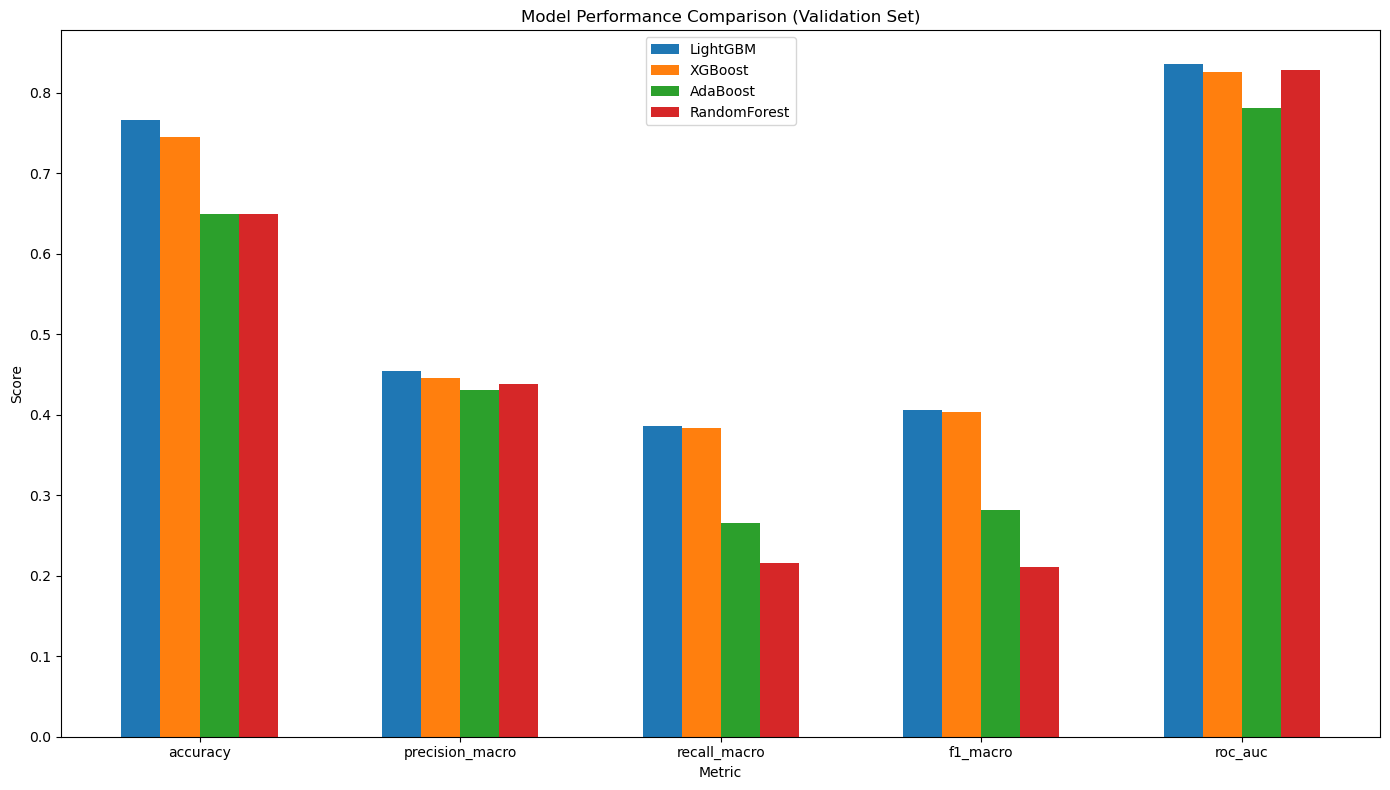

In [346]:
metrics_to_plot = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
plt.figure(figsize=(14, 8))

# Create bar chart
bar_width = 0.15  # Reduced from 0.2 to fit all models
x = np.arange(len(metrics_to_plot))

for i, (model_name, model_metrics) in enumerate(metrics.items()):
    plt.bar(x + i*bar_width, 
            [model_metrics[metric] for metric in metrics_to_plot], 
            width=bar_width, 
            label=model_name)

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Validation Set)')
plt.xticks(x + bar_width*1.5, metrics_to_plot)  # Center the x-axis labels
plt.legend()
plt.tight_layout()
plt.show()

In [215]:

# Twelfth cell - Select best model and evaluate on test set
# Select best model based on F1 score
best_model_name = model_comparison['f1_macro'].idxmax()
best_model = models[best_model_name]
print(f"Best model based on F1 score: {best_model_name}")

# Make predictions on test set
test_pred = best_model.predict(X_test_processed)
test_prob = best_model.predict_proba(X_test_processed)

# Calculate metrics on test set
test_metrics = calculate_metrics(y_test_encoded, test_pred, test_prob)

# Display test metrics
print(f"\n{best_model_name} Test Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Display classification report
print(f"\n{best_model_name} Test Set Classification Report:")
print(classification_report(y_test_encoded, test_pred, target_names=le.classes_))

Best model based on F1 score: LightGBM

LightGBM Test Set Metrics:
accuracy: 0.8147
precision_macro: 0.5864
recall_macro: 0.4939
f1_macro: 0.5261
roc_auc: 0.7956

LightGBM Test Set Classification Report:
                  precision    recall  f1-score   support

African American       0.86      0.68      0.76        37
           Asian       0.68      0.71      0.69        38
       Caucasian       0.86      0.94      0.90       139
 Hispanic/Latino       0.62      0.38      0.48        13
     Multiracial       0.50      0.25      0.33         4
           Other       0.00      0.00      0.00         1

        accuracy                           0.81       232
       macro avg       0.59      0.49      0.53       232
    weighted avg       0.80      0.81      0.80       232



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

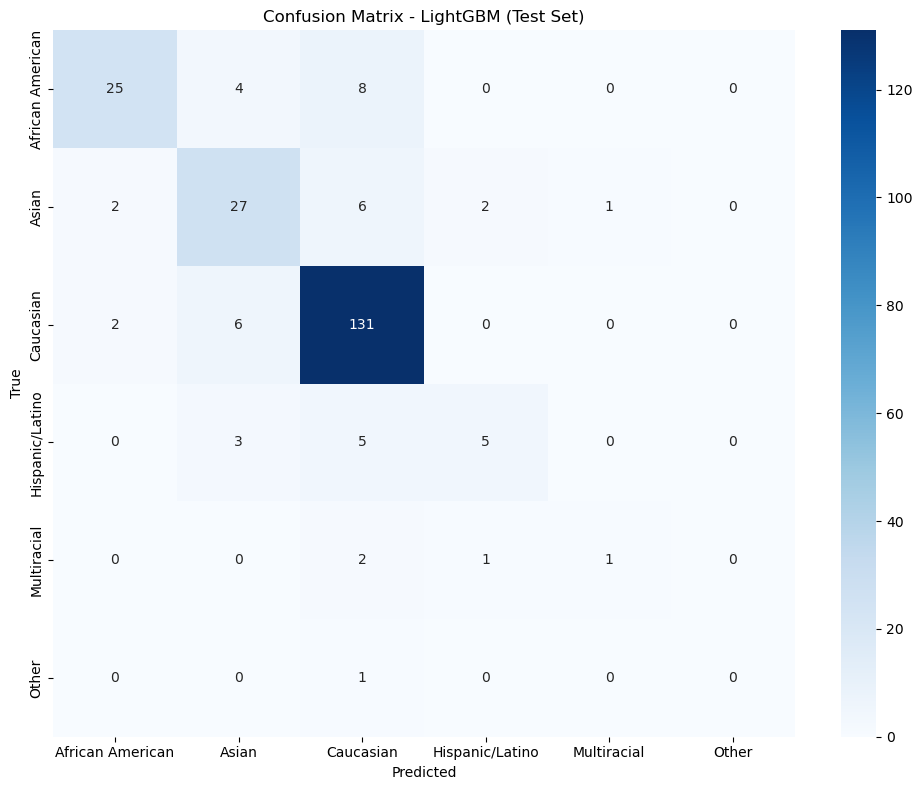

In [217]:
# Thirteenth cell - Create confusion matrix for best model
# Create confusion matrix
cm = confusion_matrix(y_test_encoded, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.tight_layout()
plt.show()

In [221]:


# Fourteenth cell - Analyze feature importance for best model
# Extract feature names
def get_feature_names(preprocessor):
    # Get numerical feature names
    numerical_features = numerical_cols
    
    # Get categorical feature names with one-hot encoding
    categorical_features = ['Sex']
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
    
    # Combine all feature names
    feature_names = list(numerical_features.copy())
    feature_names.extend(cat_feature_names)
    
    return feature_names

# Check if the best model supports feature importance
if best_model_name in ['LightGBM', 'XGBoost']:
    # Get feature names
    feature_names = get_feature_names(preprocessor)

    # Get feature importance
    importances = best_model.feature_importances_

    print(importances)
    
    # Create dataframe for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Display top features
    print(f"Top 15 Important Features - {best_model_name}:")
    print(feature_importance_df.head(15))
else:
    print(f"Feature importance visualization not implemented for {best_model_name}")


[ 0  0  0 ... 67 66 46]
Top 15 Important Features - LightGBM:
        Feature  Importance
26355       Age         695
26356       BMI         660
1574    ASV1575         166
1450    ASV1451         113
1513    ASV1514         100
1449    ASV1450          98
7188    ASV7189          97
9671    ASV9672          97
1448    ASV1449          94
1530    ASV1531          87
12681  ASV12682          82
18150  ASV18151          70
26357     Sex_           67
26358     Sex_F          66
1453    ASV1454          65


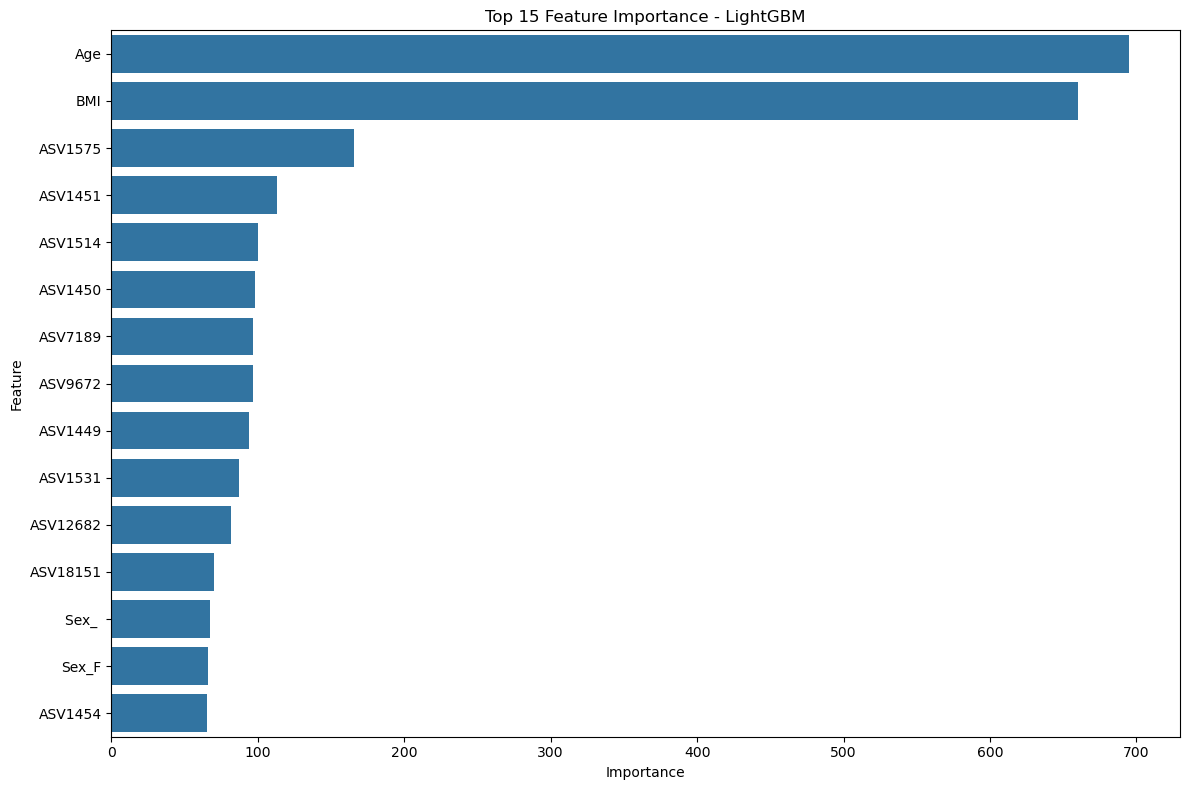

In [223]:
# Fifteenth cell - Visualize feature importance
if best_model_name in ['LightGBM', 'XGBoost']:
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()


In [225]:

# Sixteenth cell - Compare performance across datasets
# Calculate metrics on development set
dev_pred = best_model.predict(X_dev_processed)
dev_prob = best_model.predict_proba(X_dev_processed)
dev_metrics = calculate_metrics(y_dev_encoded, dev_pred, dev_prob)

# Create performance comparison dataframe
performance_comparison = pd.DataFrame({
    'Development': dev_metrics,
    'Validation': metrics[best_model_name],
    'Test': test_metrics
})

# Display performance comparison
print(f"Performance Comparison for {best_model_name} Across Datasets:")
performance_comparison

Performance Comparison for LightGBM Across Datasets:


,Development,Validation,Test
accuracy,0.979592,0.766234,0.814655
precision_macro,0.980873,0.454133,0.586380
recall_macro,0.988752,0.386356,0.493877
f1_macro,0.984702,0.405635,0.526111
roc_auc,0.999337,0.835936,0.795594


In [257]:
!pip install shap

   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/531.1 kB ? eta -:--:--
   ---------------------------------------- 531.1/531.1 kB 4.3 MB/s eta 0:00:00


In [259]:
import shap

# Shapley Interpreatation